## Random selection of sqrt(n) features

In [ ]:
import pandas as pd
import numpy as np
import math

df = pd.read_csv('DATA(1).csv')

print(math.sqrt(len(df.axes[1])-1))
df

FileNotFoundError: [Errno 2] No such file or directory: 'DATA(1).csv'

Select **6 random features**

In [61]:
rng = [ 'Weekly sleep hours','Career aspirations',
        'Weekly study hours','Student Age',
       "Father's education", 'Parents marital status']

## Построение дерева решений методом C4.5

1. Определим энтропию на всём множестве $T$. Энтропия определяет насколько беспорядочен набор данных. В наборе $T$ есть $k$ элементов - классы $C_j$:

$$
\text{Info}(T) = -\sum_{j=1}^k \frac{\text{freq}(C_j, T)}{|T|} \cdot \log_2 \left(\frac{\text{freq}(C_j, T)}{|T|}\right)
$$

In [62]:
import numpy as np
import pandas as pd 
import math
from collections import Counter 

def entropy(T):
    _, cnts = np.unique(T, return_counts=True)
    return -sum((cnt / len(T)) * math.log2(cnt / len(T)) for cnt in cnts)

entropy(df["GRADE"])

2.861968363284211

2. После разбиения множества $T$ по атрибуту X, образуются подмножества $T_1, T_2, ..., T_n$. Можем посчитать условную энтропию - разброс полученного подмножества относительно всего множества $T$:

$$
\text{Info}_X (T) = \sum_{i=1}^n \frac{|T_i|}{|T|} \cdot Info(T_i)
$$

In [63]:
def conditional_entropy(T, attr): 
    total = len(T) 
    acc = 0
    for val in T[attr].unique():
        subset = T[T[attr] == val]
        acc += (len(subset) / len(T)) * entropy(subset['GRADE'])
        
    return acc

3. Чтобы корректно вычислить прирост информации, следует также его нормировать, учтя уникальность значений атрибутов и их влияние на структуру дерева. Для этого используется критерий $Split \,\, information$:

$$
\text{split}_{\text{info}} (X) = -\sum_{i=1}^n \frac{|T_i|}{|T|} \cdot \log_2 \left(\frac{|T_i|}{|T|}\right)
$$

In [64]:
def split(T, attr): 
    total = len(T) 
    acc = 0
    for val in T[attr].unique():
        cnt = len(T[T[attr] == val])
        weight = cnt / total
        if weight > 0:
            acc -= weight * math.log2(weight)
        
    return acc

4. Итак, теперь можно подсчитать прирост информации, нормированный критерием Split information. На его основе будет сделан выбор наилучшего атрибута на каждом уровне дерева:

$$
\text{Gain\_ratio} (X) = \frac{\text{Info} (T) - \text{Info}_X (T)}{\text{split}_\text{info} (X)}
$$

In [65]:
def gain(T, attr):
    split_info_value = split(T, attr)
    if split_info_value == 0:
        return 0
    return (entropy(T['GRADE']) - conditional_entropy(T, attr)) / split_info_value

5. Построение дерева

In [66]:
def most_common_class(T):
    return T['GRADE'].mode()[0]

def build_tree(T, attrs):
    if len(T['GRADE'].unique()) == 1:
        return T['GRADE'].iloc[0]
    
    if len(attrs) == 0:
        return most_common_class(T)

    gains = {attr: gain(T, attr) for attr in attrs}
    best_attribute = max(gains, key=gains.get)

    tree = {best_attribute: {}}

    for value in T[best_attribute].unique():
        subset = T[T[best_attribute] == value].drop(columns=[best_attribute])
        subtree = build_tree(subset, [attr for attr in attrs if attr != best_attribute])
        tree[best_attribute][value] = subtree

    return tree

rng_nums = ['10', '20', '1', '25', '12', '15']
decision_tree = build_tree(df, rng_nums)
print(decision_tree)


{'1': {2: {'20': {1: {'15': {2: {'25': {3: {'10': {1: {'12': {2: 1, 3: 1, 1: 3, 4: 1, 5: 6}}, 3: {'12': {4: 5, 3: 1}}, 2: {'12': {4: 7, 3: 2}}}}, 2: {'10': {2: {'12': {2: 0, 4: 1, 1: 5, 3: 1}}, 4: 1, 1: {'12': {1: 1, 2: 1, 3: 5}}}}, 1: {'12': {3: 2, 2: 2, 1: {'10': {1: 0}}}}}}, 4: {'10': {2: {'12': {3: 5, 4: 3}}, 1: {'12': {1: 2, 4: 4}}, 3: 6}}, 3: {'10': {2: 1, 1: 4, 3: {'25': {3: 1, 2: 4}}}}, 5: 3, 1: {'10': {1: {'25': {3: 7, 2: 6}}, 2: 2}}}}, 2: {'12': {4: {'25': {3: 2, 2: 1}}, 2: {'25': {2: 2, 3: 1}}, 3: 6, 1: {'10': {3: 2, 1: {'25': {2: 2, 3: 1}}}}}}}}, 1: {'12': {2: {'25': {3: {'10': {2: {'20': {1: {'15': {2: 1, 4: 1}}, 2: 3}}, 1: {'20': {1: {'15': {2: 1}}, 2: {'15': {2: 1}}}}, 3: {'20': {1: 7, 2: 1}}}}, 2: {'10': {1: {'20': {1: {'15': {2: 1}}}}, 2: 7}}}}, 3: {'15': {2: {'10': {3: {'20': {2: 5, 1: {'25': {2: 6, 3: 6}}}}, 2: {'25': {3: {'20': {1: 1, 2: 1}}, 2: 7}}, 1: {'25': {2: {'20': {1: 2}}, 3: {'20': {1: 1}}}}}}, 4: {'10': {3: {'20': {1: 2, 2: 3}}, 1: 7}}, 3: {'10': {2: {'20':

In [71]:
def predict(tree, sample, default="Unknown"):
    if not isinstance(tree, dict):
        return tree

    attribute = next(iter(tree))
    value = sample.get(attribute)
    
    if value not in tree[attribute]:
        return default  # value not found

    subtree = tree[attribute][value]
    return predict(subtree, sample, default)

In [72]:
df['Predicted GRADE'] = predict_dataframe(decision_tree, df)
print(df[['STUDENT ID', 'Predicted GRADE']])

     STUDENT ID  Predicted GRADE
0      STUDENT1                1
1      STUDENT2                1
2      STUDENT3                0
3      STUDENT4                1
4      STUDENT5                1
..          ...              ...
140  STUDENT141                0
141  STUDENT142                5
142  STUDENT143                1
143  STUDENT144                4
144  STUDENT145                1

[145 rows x 2 columns]


## Оценка реализованного алгоритма

### Достоверность (правильность)

$\text{accuracy}=\frac{\text{TP}+\text{TN}}{N}$

### Точность (способность отличать этот класс от других)

$\text{precision}=\frac{\text{TP}}{\text{TP}+\text{FP}}$

### Полнота (способность обнаруживать данный класс, sensitivity)

$\text{recall}=\frac{\text{TP}}{\text{TP}+\text{FN}}$

In [78]:
import numpy as np

df['Actual_Binary'] = df['GRADE'].apply(lambda x: 1 if x > 3 else 0)
df['Predicted_Binary'] = df['Predicted GRADE'].apply(lambda x: 1 if x > 3 else 0)

actual = df['Actual_Binary'].values
predicted = df['Predicted_Binary'].values

accuracy = np.mean(actual == predicted)

true_positive = np.sum((predicted == 1) & (actual == 1))
false_positive = np.sum((predicted == 1) & (actual == 0))
false_negative = np.sum((predicted == 0) & (actual == 1))

precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")

Accuracy: 0.84828
Precision: 0.94872
Recall: 0.64912


In [155]:
def build_tree(T, attrs):
    positive_class = T['GRADE'].apply(lambda x: 1 if x > 3 else 0)
    class_counts = positive_class.value_counts()
    total = len(positive_class)
    probabilities = {
        0: class_counts.get(0, 0) / total,
        1: class_counts.get(1, 0) / total
    }
    
    if len(class_counts) == 1 or len(attrs) == 0:
        return {'probabilities': probabilities}
    
    gains = {attr: gain(T, attr) for attr in attrs}
    best_attribute = max(gains, key=gains.get)
    
    tree = {
        'probabilities': probabilities,
        'feature': best_attribute,
        'subtrees': {}
    }
    
    for value in T[best_attribute].unique():
        subset = T[T[best_attribute] == value]
        remaining_attrs = [attr for attr in attrs if attr != best_attribute]
        subtree = build_tree(subset, remaining_attrs)
        tree['subtrees'][value] = subtree
    
    return tree

In [159]:
def predict(tree, sample, default_probabilities=None):
    if 'probabilities' in tree:
        probabilities = tree['probabilities']
    else:
        probabilities = default_probabilities or {0: 0.5, 1: 0.5}
    
    if 'feature' not in tree or tree['feature'] not in sample:
        return probabilities[1]  # Вероятность положительного класса
    
    feature_value = sample[tree['feature']]
    subtrees = tree['subtrees']
    
    if feature_value in subtrees:
        subtree = subtrees[feature_value]
        return predict(subtree, sample, probabilities)
    else:
        # Если значение не найдено, используем вероятности текущего узла
        return probabilities[1]

In [161]:
def predict_dataframe(tree, df):
    predictions = []
    for _, row in df.iterrows():
        sample = row.to_dict()
        prob = predict(tree, sample)
        predictions.append(prob)
    return predictions

# Получаем предсказанные вероятности
# Построение дерева
rng_nums = ['10', '20', '1', '25', '12', '15']
decision_tree = build_tree(df, rng_nums)

# Предсказание вероятностей
df['Predicted_Probability'] = predict_dataframe(decision_tree, df)

# Проверяем результаты
print(df['Predicted_Probability'])

0      0.500000
1      0.400000
2      0.333333
3      0.333333
4      0.000000
         ...   
140    0.333333
141    1.000000
142    0.000000
143    1.000000
144    0.333333
Name: Predicted_Probability, Length: 145, dtype: float64


In [167]:
import numpy as np

df['Actual_Binary'] = df['GRADE'].apply(lambda x: 1 if x > 3 else 0)

y_true = df['Actual_Binary'].values
y_scores = df['Predicted_Probability'].values

y_scores = np.clip(y_scores, 0, 1)

In [166]:
thresholds = np.unique(y_scores)
tprs = []
fprs = []

for thresh in thresholds:
    y_pred = (y_scores >= thresh).astype(int)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    tprs.append(tpr)
    fprs.append(fpr)

sorted_indices = np.argsort(fprs)
fprs = np.array(fprs)[sorted_indices]
tprs = np.array(tprs)[sorted_indices]

auc_roc = np.trapz(tprs, fprs)
print(f"AUC-ROC: {auc_roc:.2f}")

AUC-ROC: 0.95


In [168]:
precisions = []
recalls = []

for thresh in thresholds:
    y_pred = (y_scores >= thresh).astype(int)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 1
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

precisions.append(1)
recalls.append(0)

recalls, precisions = zip(*sorted(zip(recalls, precisions)))

auc_pr = np.trapz(precisions, recalls)
print(f"AUC-PR: {auc_pr:.2f}")

AUC-PR: 0.93


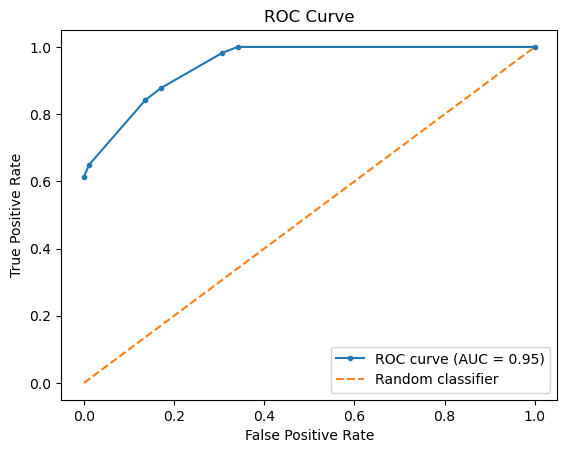

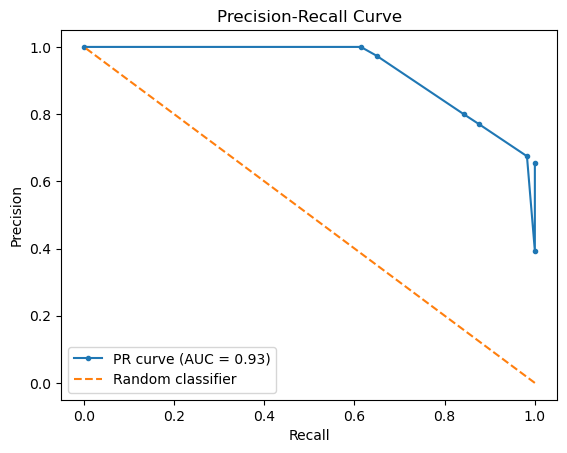

In [170]:
import matplotlib.pyplot as plt

# ROC-кривая
plt.figure()
plt.plot(fprs, tprs, marker='.', label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# PR-кривая
plt.figure()
plt.plot(recalls, precisions, marker='.', label='PR curve (AUC = {:.2f})'.format(auc_pr))
plt.plot([1, 0], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()